# Impulse Noise Restoration via CSC

This notebook demonstrates the use of SPORCO to remove salt & pepper noise from a colour image using convolutional sparse coding with a colour dictionary,

$$\mathrm{argmin}_\mathbf{x} \; (1/2) \sum_c \left\| \sum_m \mathbf{d}_{c,m} * \mathbf{x}_m -\mathbf{s}_c \right\|_2^2 + \lambda \sum_m \| \mathbf{x}_m \|_1 + (\mu/2) \sum_i \sum_m \| G_i \mathbf{x}_m \|_2^2$$

where $\mathbf{d}_{c,m}$ is channel $c$ of the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_m$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, $\mathbf{s}_c$ is channel $c$ of the input image, and $G_i$ is an operator computing the derivative along spatial index $i$. 


Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
import sporco.metric as sm
from sporco.admm import cbpdn

%matplotlib inline

Boundary artifacts are handled by performing a symmetric extension on the image to be denoised and then cropping the result to the original image support. This approach is simpler than the boundary handling strategies that involve the insertion of a spatial mask into the data fidelity term, and for many problems gives results of comparable quality. The functions defined here implement symmetric extension and cropping of images.

In [2]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

Load a reference image and corrupt it with 33% salt and pepper noise. (The call to ``np.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, 160:672])


np.random.seed(12345)
imgn = util.spnoise(img, 0.33)

We use a colour dictionary. The impulse denoising problem is solved by appending some additional filters to the learned dictionary ``D0``, which is one of those distributed with SPORCO. The first of these additional components is a set of three impulse filters, one per colour channel, that will represent the impulse noise, and the second is an identical set of impulse filters that will represent the low frequency image components when used together with a gradient penalty on the coefficient maps, as discussed below.

In [4]:
D0 = util.convdicts()['RGB:8x8x3x64']
Di = np.zeros(D0.shape[0:2] + (3, 3))
np.fill_diagonal(Di[0, 0], 1.0)
D = np.concatenate((Di, Di, D0), axis=3)

The problem is solved using class ``admm.cbpdn.ConvBPDNGradReg``, which implements the form of CBPDN with an additional gradient regularization term, as defined above. The regularization parameters for the $\ell_1$ and gradient terms are ``lmbda`` and ``mu`` respectively. Setting correct weighting arrays for these regularization terms is critical to obtaining good performance. For the $\ell_1$ norm, the weights on the filters that are intended to represent the impulse noise are tuned to an appropriate value for the impulse noise density (this value sets the relative cost of representing an image feature by one of the impulses or by one of the filters in the learned dictionary), the weights on the filters that are intended to represent low frequency components are set to zero (we only want them penalised by the gradient term), and the weights of the remaining filters are set to zero. For the gradient penalty, all weights are set to zero except for those corresponding to the filters intended to represent low frequency components, which are set to unity.

In [5]:
lmbda = 2.8e-2
mu = 3e-1
w1 = np.ones((1, 1, 1, 1, D.shape[-1]))
w1[..., 0:3] = 0.33
w1[..., 3:6] = 0.0
wg = np.zeros((D.shape[-1]))
wg[..., 3:6] = 1.0
opt = cbpdn.ConvBPDNGradReg.Options({'Verbose': True, 'MaxMainIter': 100,
                    'RelStopTol': 5e-3, 'AuxVarObj': False,
                    'L1Weight': w1, 'GradWeight': wg})

Initialise the ``cbpdn.ConvBPDNGradReg`` object and call the ``solve`` method.

In [6]:
b = cbpdn.ConvBPDNGradReg(D, pad(imgn), lmbda, mu, opt, dimK=0)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     Regℓ2∇    r         s         ρ         
--------------------------------------------------------------------------
   0  8.93e+03  7.67e+03  3.96e+04  5.00e+02  4.37e-01  6.89e+00  2.40e+00
   1  2.08e+03  4.99e+02  4.46e+04  1.12e+03  9.88e-02  1.85e+00  2.40e+00
   2  2.28e+03  8.35e+01  7.50e+04  3.06e+02  2.03e-01  7.76e-01  5.07e-01
   3  3.19e+03  2.09e+01  1.13e+05  7.35e+01  2.84e-01  3.94e-01  2.37e-01
   4  3.08e+03  9.88e+00  1.09e+05  4.02e+01  2.72e-01  2.80e-01  1.83e-01
   5  2.75e+03  8.30e+00  9.76e+04  3.57e+01  2.36e-01  2.30e-01  1.65e-01
   6  2.25e+03  7.59e+00  7.97e+04  3.64e+01  1.88e-01  1.96e-01  1.65e-01
   7  2.02e+03  7.30e+00  7.16e+04  3.65e+01  1.67e-01  1.70e-01  1.47e-01
   8  1.82e+03  6.79e+00  6.44e+04  3.65e+01  1.46e-01  1.45e-01  1.33e-01
   9  1.55e+03  6.39e+00  5.48e+04  3.62e+01  1.17e-01  1.25e-01  1.33e-01
  10  1.44e+03  6.06e+00  5.08e+04  3.60e+01  1.06e-01  1.09e-01  1.18e-01
  11  1.32e+03  5.80e+0

The denoised estimate of the image is just the reconstruction from all coefficient maps except those that represent the impulse noise, which is why we subtract the slice of ``X`` corresponding the impulse noise representing filters from the result of ``reconstruct``.

In [7]:
imgdp = b.reconstruct().squeeze() - X[..., 0, 0:3].squeeze()
imgd = crop(imgdp)
print('%.3f dB   %.3f dB' % (sm.psnr(img, imgn), sm.psnr(img, imgd)))

10.367 dB   26.411 dB


Display the reference, noisy, and denoised images.

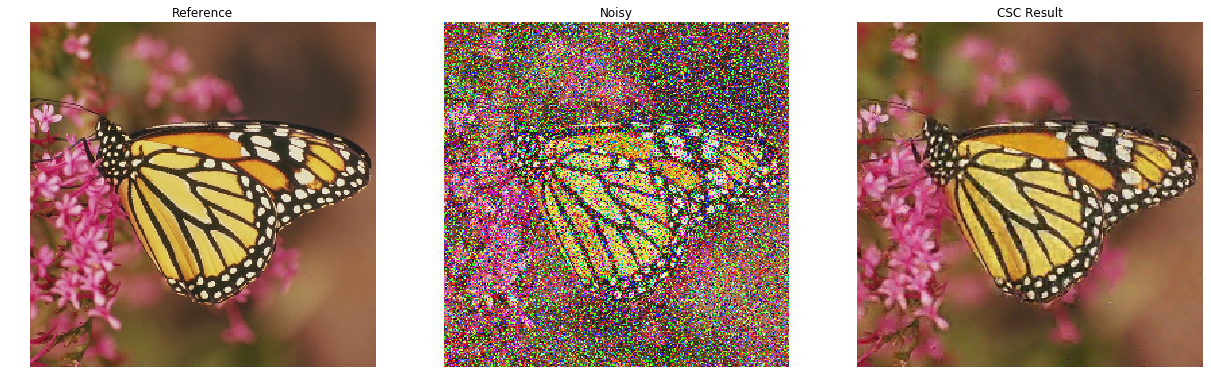

In [8]:
fig1 = plot.figure(1, figsize=(21, 7))
plot.subplot(1,3,1)
fgax = plot.imview(img, fgrf=fig1, title='Reference')
plot.subplot(1,3,2)
fgax = plot.imview(imgn, fgrf=fig1, title='Noisy')
plot.subplot(1,3,3)
fgax = plot.imview(imgd, fgrf=fig1, title='CSC Result')


Plot functional evolution during ADMM iterations.

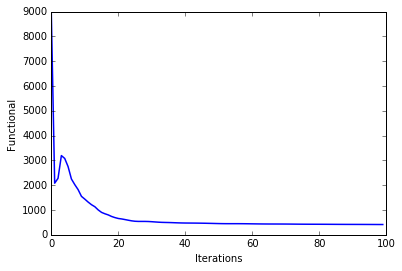

In [9]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

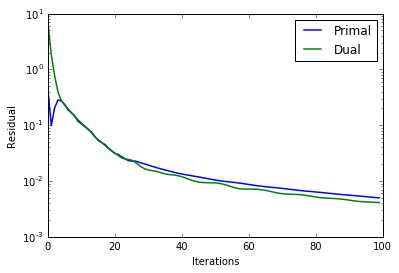

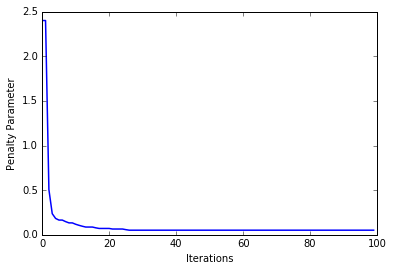

In [10]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()